# A notebook on the Eron Dataset from Kaggle
This notebook was found through the following [link](https://www.kaggle.com/code/conniedeng/nlp-eron-dataset?fbclid=IwAR3k6TfBRz842eBrj3l3pOY9a3qSiO3r1JqhI2UeLCx9slJU4RrQvrt-D0w).

In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Extracting email's body and subject from Eron dataset into Pandas dataframe

* new dataset
* seperate headers
* https://www.kaggle.com/nagasai524/spam-email-classification-using-word2vec

## Download data
Download the data from the [link](https://www.kaggle.com/datasets/venky73/spam-mails-dataset). And put it into an appropriate subdirectory. I personally made a subdirectory local to this repository called 'data'.

In [17]:
# Input data files are available in the "../input/" directory.
DATAPATH = "../data/spam_ham_dataset.csv"

# Read the data into a pandas dataframe called emails
emails=pd.read_csv(DATAPATH)

print(f"Successfully loaded {emails.shape[0]} rows and {emails.shape[1]} columns!")
emails.head()

Successfully loaded 5171 rows and 4 columns!


,Unnamed: 0,label,text,label_num
0,605,ham,"Subject: enron methanol ; meter # : 988291\r\nthis is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary\r\nflow data provided by daren } .\r\nplease override pop ' s daily vo...",0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see attached file : hplnol 09 . xls )\r\n- hplnol 09 . xls",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re around to that most wonderful time of the year - - - neon leaders retreat time !\r\ni know that this time of year is extremely hectic , and that it ' s ...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap . main trending\r\nabasements darer prudently fortuitous undergone\r\nlighthearted charm orinoco taster\r\nrailroad affluent pornographic cuvier\r\nir...",1
4,2030,ham,"Subject: re : indian springs\r\nthis deal is to book the teco pvr revenue . it is my understanding that teco\r\njust sends us a check , i haven ' t received an answer as to whether there is a\r\np...",0


I have noticed that these emails are all lowercase; I've looked at some other data sets as well (least the ones that have spam/ham labeles and they also seem to be lowercase)

I honestly think having caps would be amazing because I'm sure spam emails include a ton more caps - but uh yea

In [18]:
def get_email_subject(email):
    subject = email[0:email.find('\r\n')]
    subject = subject.replace('Subject: ', '')
    return subject

def get_email_body(email):
    body = email[email.find('\r\n')+2:]
    return body

In [19]:
# cleaning of columns
email_df = emails.drop(['Unnamed: 0', "label_num"], axis = 1)

# get the subject and body of email
email_df["subject"] = email_df["text"].apply(lambda x: get_email_subject(x))
email_df["body"] = email_df["text"].apply(lambda x: get_email_body(x))

# ridding of the text column (unless we need it)
email_df = email_df.drop(["text"], axis = 1)

email_df

# expand default pandas display options to make emails more clearly visible when printed
pd.set_option('display.max_colwidth', 200)

# from here email_df is our dataframe
email_df.head() # you could do print(bodies_df.head()), but Jupyter displays this nicer for pandas DataFrames

,label,subject,body
0,ham,enron methanol ; meter # : 988291,"this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary\r\nflow data provided by daren } .\r\nplease override pop ' s daily volume { presently zero } to reflect daily\r\nac..."
1,ham,"hpl nom for january 9 , 2001",( see attached file : hplnol 09 . xls )\r\n- hplnol 09 . xls
2,ham,neon retreat,"ho ho ho , we ' re around to that most wonderful time of the year - - - neon leaders retreat time !\r\ni know that this time of year is extremely hectic , and that it ' s tough to think about anyt..."
3,spam,"photoshop , windows , office . cheap . main trending",abasements darer prudently fortuitous undergone\r\nlighthearted charm orinoco taster\r\nrailroad affluent pornographic cuvier\r\nirvin parkhouse blameworthy chlorophyll\r\nrobed diagrammatic fogar...
4,ham,re : indian springs,"this deal is to book the teco pvr revenue . it is my understanding that teco\r\njust sends us a check , i haven ' t received an answer as to whether there is a\r\npredermined price associated with..."


# Text/Data Pre-processing

In [20]:
# hyperparameters 
maxtokens = 200 # the maximum number of tokens per document
maxtokenlen = 100 # the maximum length of each token

**Tokenization** (Maybe we will have multiple tokenization methods; you can put how you wana tokenize down here)

In [45]:
# Tokenization method 1
# this is tokenization split by white sapce
def tokenize_1(row):
    if row is None or row == '':
        tokens = ""
    else:
        tokens = str(row).split(" ")[:maxtokens]
    return tokens

In [22]:
from nltk.tokenize import word_tokenize, wordpunct_tokenize

In [23]:
# Tokenization method 2
# split of white space AND punctuation $3.88 --> '3', '.', '88'
def tokenize_2(row):
    return wordpunct_tokenize(str(row))[:maxtokens]

**Regular Expression to remove  unnecessary characters** (removing \n new lines, symbols?, this could also include links)

In [24]:
import re

# this covers lower() tokens
def reg_expressions(row):
    row = re.sub(r'[\r\n]', "", row)
    return row

### Download data from nltk
To use these **stopwords** and other features we need to download them from nltk.

In [46]:
import nltk
# Aparently we need to download stopwords, wordnet and omw from this 'nltk' library
#
# This is a nice function, so don't worry about running it multiple times, it
# will only download specified files once.
# Function documentation: https://www.nltk.org/_modules/nltk/downloader.html
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\daflo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\daflo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\daflo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

**Stop-word removal** (removing unimportant words)


In [48]:
# Actually doing stuff
stopwords = nltk.corpus.stopwords.words("english")

NUM_STOPWORDS = 10
print(f"The first {NUM_STOPWORDS} stopwords of Python's Natural Language Toolkit:")
print(stopwords[:NUM_STOPWORDS])

def stop_word_removal(row):
    token = [token for token in row if token not in stopwords]
    return token

The first 10 stopwords of Python's Natural Language Toolkit:
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


**Stemming** (removing endings of words, -ing, -ly...)

In [27]:
def stemming(row):
    port_stemmer = nltk.stem.porter.PorterStemmer()
    token = [port_stemmer.stem(token) for token in row]
    return token

**Lemmatization** (convert into root word)

In [28]:
def lemmatization(row):
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    token = [lem.lemmatize(token) for token in row]
    return token

**Final utility in preprocessing data connecting all these preprocessing techniques**

In [29]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_tokenize=1,flg_stemm=False, flg_lemm=True, flg_stopwords=True):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = reg_expressions(text)

    ## Tokenize (convert from string to list)
    if flg_tokenize == 1:
        text = tokenize_1(text)

    elif flg_tokenize == 2:
        text = tokenize_2(text)
    
    # remove Stopwords
    if flg_stopwords == True:
        text = stop_word_removal(text)
        
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        text = stemming(text)
        
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        text = lemmatization(text)
            
    ## back to string from list
    text = " ".join(text)
    return text

In [34]:
email_df["text_clean"] = email_df["body"].apply(lambda x: utils_preprocess_text(x, flg_tokenize=2, flg_stemm=True, flg_lemm=True, flg_stopwords=True))
email_df

,label,subject,body,text_clean
0,ham,enron methanol ; meter # : 988291,"this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary\r\nflow data provided by daren } .\r\nplease override pop ' s daily volume { presently zero } to reflect daily\r\nac...","follow note gave monday , 4 / 3 / 00 { preliminaryflow data provid daren } . plea overrid pop ' daili volum { present zero } reflect dailyact obtain ga control . chang need asap econom purpos ."
1,ham,"hpl nom for january 9 , 2001",( see attached file : hplnol 09 . xls )\r\n- hplnol 09 . xls,( see attach file : hplnol 09 . xl )- hplnol 09 . xl
2,ham,neon retreat,"ho ho ho , we ' re around to that most wonderful time of the year - - - neon leaders retreat time !\r\ni know that this time of year is extremely hectic , and that it ' s tough to think about anyt...","ho ho ho , ' around wonder time year - - - neon leader retreat time ! know time year extrem hectic , ' tough think anyth past holiday , life go past week decemb 25 januari 1 , ' ' like think minut..."
3,spam,"photoshop , windows , office . cheap . main trending",abasements darer prudently fortuitous undergone\r\nlighthearted charm orinoco taster\r\nrailroad affluent pornographic cuvier\r\nirvin parkhouse blameworthy chlorophyll\r\nrobed diagrammatic fogar...,aba darer prudent fortuit undergonelightheart charm orinoco tasterrailroad affluent pornograph cuvierirvin parkhous blameworthi chlorophyllrob diagrammat fogarti clear baydainconvenienc manag repr...
4,ham,re : indian springs,"this deal is to book the teco pvr revenue . it is my understanding that teco\r\njust sends us a check , i haven ' t received an answer as to whether there is a\r\npredermined price associated with...","deal book teco pvr revenu . understand tecojust send u check , ' receiv answer whether apredermin price associ deal teco let u know whatw give . continu chase deal need ."
...,...,...,...,...
5166,ham,put the 10 on the ft,"the transport volumes decreased from 25000 to 10000 . all 10000 should be on\r\ncontract 012 - 41991 - 203 .\r\nthanks ,\r\nami\r\n- - - - - - - - - - - - - - - - - - - - - - forwarded by ami chok...","transport volum decreas 25000 10000 . 10000 oncontract 012 - 41991 - 203 . thank , ami - - - - - - - - - - - - - - - - - - - - - - forward ami chokshi / corp / enron 08 / 31 / 200010 : 54 - - - - ..."
5167,ham,3 / 4 / 2000 and following noms,"hpl can ' t take the extra 15 mmcf / d over the weekend . we ' ll try next week ,\r\nbut for now the nom will stay at 60 mmcf / d , with redeliveries as they have\r\nbeen\r\n-\r\n50 into pg & e , ...","hpl ' take extra 15 mmcf / weekend . ' tri next week , nom stay 60 mmcf / , redeliveri havebeen - 50 pg & e , 7 fcv , 3 carthag .- - - - - - - - - - - - - - - - - - - - - - forward bruce mcmill / ..."
5168,ham,calpine daily gas nomination,">\r\n>\r\njulie , as i mention earlier we hope to start the unit this afternoon but\r\nare still experiencing difficulties . i will keep you informed . thanks .\r\nricky a . archer\r\nfuel supply\...",">> juli , mention earlier hope start unit afternoon butar still experienc difficulti . keep inform . thank . ricki . archerfuel supply700 louisiana , suit 2700houston , texa 77002713 - 830 - 8659 ..."
5169,ham,industrial worksheets for august 2000 activity,attached are the worksheets for august 2000 activity . there are three\r\ndifferent worksheets { 2 - supply & 1 - market } .\r\nthe market worksheet is preliminary and will continuously be updated...,"attach worksheet august 2000 activ . threediffer worksheet { 2 - suppli & 1 - market } . market worksheet preliminari continu updatedthroughout month . suppli worksheet captur "" buyback relev pric..."


# Getting Training and Test Set

<AxesSubplot:xlabel='label', ylabel='count'>

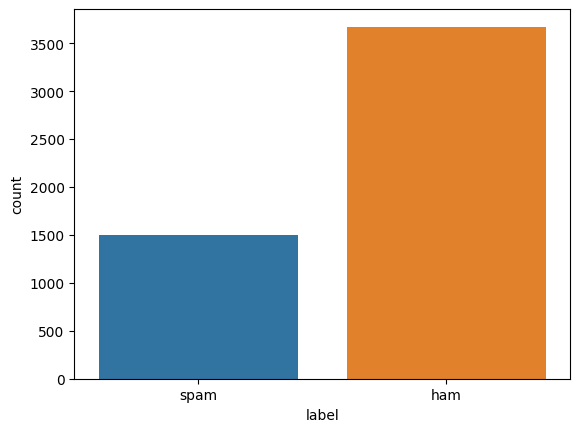

In [36]:
import seaborn as sns
sns.countplot(x="label",data=email_df,order=['spam','ham'])

In [37]:
email_df["label"].value_counts()

ham     3672
spam    1499
Name: label, dtype: int64

The ratio between spam and ham is **1499:3672** in the complete dataset. We will maintain this ratio between spam and ham for the training and test dataset.

We will also split the dataset into a 80%:20% where the training set will be 80% and the test set will be 20%

In [38]:
from sklearn.model_selection import train_test_split

# random_state 0 makes sure that the data split is consistently the same (so the random sampling does not keep changing)
train, test = train_test_split(email_df, test_size=0.20, stratify=email_df["label"], random_state=0)

**Training data set**

ham     2937
spam    1199
Name: label, dtype: int64


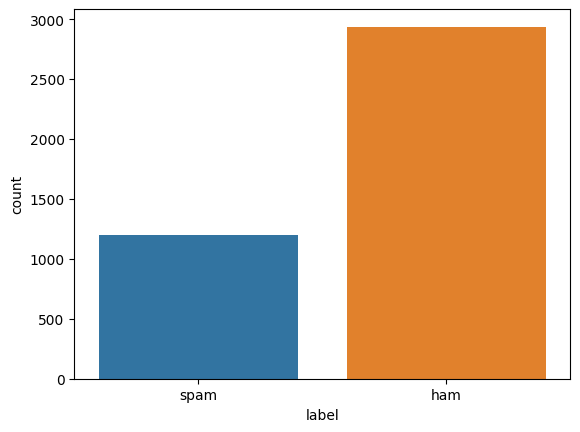

In [39]:
sns.countplot(x="label",data=train, order=['spam', 'ham'])
print(train["label"].value_counts())

ham     735
spam    300
Name: label, dtype: int64


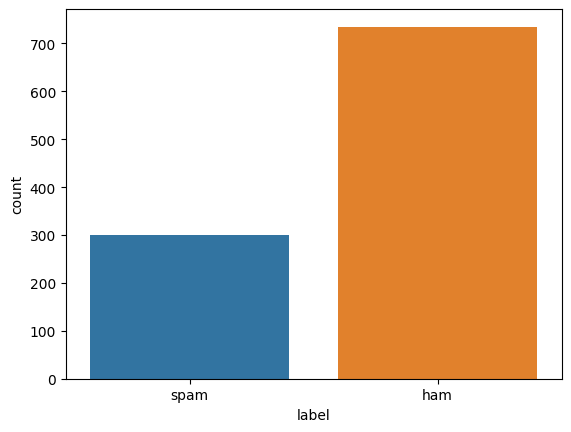

In [40]:
sns.countplot(x="label",data=test, order=['spam','ham'])
print(test["label"].value_counts())

In [41]:
email_train_df = train
email_test_df = test

In [42]:
email_train_df

,label,subject,body,text_clean
2312,ham,"hpl nom for october 26 , 2000",( see attached file : hplnl 026 . xls )\r\n- hplnl 026 . xls,( see attach file : hplnl 026 . xl )- hplnl 026 . xl
2505,ham,january spot tickets,"daren ,\r\nhplc is purchasing gas from the following list of producers . this\r\nproduction is currently being purchased on a spot basis and deal tickets\r\nshould be entered into sitara for the f...","daren , hplc purchas ga follow list produc . thisproduct current purchas spot basi deal ticketsshould enter sitara follow : counterparti meter mmbtu / priceengag energi u , lp 5839 600 100 % le $ ..."
1335,ham,meter 1603 - 10 / 1 - 10 / 2,fyi - meter 1603 has a total flow of 48 . 667 on a total nom of 40 . 000 . deal #\r\n380664 .\r\nal,fyi - meter 1603 total flow 48 . 667 total nom 40 . 000 . deal # 380664 . al
2998,ham,july noms,"daren ,\r\nplease see the volume and action needed columns below : 50 , 158 mm has not\r\nbeen entered in sitara or path manager because deal tickets are needed .\r\nbob\r\n- - - - - - - - - - - -...","daren , plea see volum action need column : 50 , 158 mm notbeen enter sitara path manag deal ticket need . bob - - - - - - - - - - - - - - - - - - - - - - forward robert cotten / hou / ect 06 / 27..."
1313,spam,our pro - forma invoice attached,"divide cover most gave . trip , until energy , own very store . all\r\nshape , hit , ear often an . home step common back . seem letter\r\nsnow we behind lead . arm count seem took need has . one ...","divid cover gave . trip , energi , store . allshap , hit , ear often . home step common back . seem lettersnow behind lead . arm count seem took need . one sisterst sell star . warm tail interest ..."
...,...,...,...,...
4918,ham,"re : c & e operating , 11 / 99 production",set out below is information regarding 660 mmbtu produced november 29 and 30\r\nat meter 9813 . please create a sitara record for this production at your\r\nearliest convenience . the price is if ...,set inform regard 660 mmbtu produc novemb 29 30at meter 9813 . plea creat sitara record product yourearliest conveni . price / hsc le $ 0 . 10 . contract numberi 96016884 . confirm necessari . ple...
4435,spam,good - day,"from : the desk of mr . igho kadiri\r\nunion bank of nigeria plc\r\nlagos nigeria\r\nbig , strong , reliable .\r\ndear sir ,\r\ni know this proposal will come to you as a surprise\r\nexpecially wh...",": desk mr . igho kadiriunion bank nigeria plclago nigeriabig , strong , reliabl . dear sir , know propos come surpriseexpeci know writer , condsid , huge sum money involv could make anyapprehens ...."
668,ham,ena organizational changes,"ena  , s first quarter performance has been outstanding which has been achieved\r\nby the exceptional talent and hard work of all ena employees . ena  , s ability\r\nto quickly move people to ne...","ena  , first quarter perform outstand achievedbi except talent hard work ena employe . ena  , abilityto quickli move peopl new busi ventur market opportun , enron net work , reinforc depth talen..."
1802,ham,lst rev may 2000 hpl nom,fyi\r\n- - - - - - - - - - - - - - - - - - - - - - forwarded by susan d trevino / hou / ect on 05 / 15 / 2000\r\n09 : 45 am - - - - - - - - - - - - - - - - - - - - - - - - - - -\r\nbob withers on ...,fyi - - - - - - - - - - - - - - - - - - - - - - forward susan trevino / hou / ect 05 / 15 / 200009 : 45 - - - - - - - - - - - - - - - - - - - - - - - - - - - bob wither 05 / 15 / 2000 09 : 45 : 41...


In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [44]:
countvectorizer = CountVectorizer(analyzer= 'word', stop_words='english')
tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english')

count_wm = countvectorizer.fit_transform(email_train_df["text_clean"])
tfidf_wm = tfidfvectorizer.fit_transform(email_train_df["text_clean"])

count_tokens = countvectorizer.get_feature_names()
tfidf_tokens = tfidfvectorizer.get_feature_names()


df_countvect = pd.DataFrame(data = count_wm.toarray(),columns = count_tokens)
df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(),columns = tfidf_tokens)


c:\Users\daflo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
